In [1]:
import xarray as xr
import xradar as xd
import cartopy.crs as ccrs
from datatree import open_datatree
import hvplot.xarray 
import matplotlib.pyplot as plt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib import colors
from cartopy import geodesic
import shapely
import numpy as np
import pyproj
import pandas as pd
from wradlib.georef import epsg_to_osr, georeference
from dask.distributed import Client, LocalCluster
import hvplot.xarray
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

In [3]:
def rain_rate(z, a=200, b=1.6):
    z_lin = 10 ** (z / 10)
    return ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (5 / 60)


def dia_met(year, month, day, num_days):
    end =  pd.Timestamp(year, month, day, 7, 0, tz='America/Bogota').tz_convert('UTC')
    start = pd.Timestamp(year, month, day, 6, 59, tz='America/Bogota').tz_convert('UTC') - pd.Timedelta(f'{num_days}D')
    return start, end
    

def color_bar():
    """
    :return:
    """
    hex_colors = ["#FFFFFF", "#00FFFF", "#00DBFF", "#0092FF",  "#0000FF", "#00FF00",  "#00DB00", "#009200", "#FFFF00",
                  "#FF9200", "#FF6D00", "#FF0000", "#FF2400", "#B60000", "#6D49DB"]

    accum_cmap = colors.ListedColormap(hex_colors, 'IDEAM_ACCUM')
    n_bins = [0, 0.1, 1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 60, 80, 100, 1000]
    norm = colors.BoundaryNorm(boundaries=n_bins, ncolors=len(n_bins))
    return accum_cmap, norm, n_bins

def get_lon_lat(rr, lon, lat, data_crs):
    x, y = data_crs.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
    abslat = np.abs(rr.y - y)
    abslon = np.abs(rr.x - x)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    return rr.isel(range=yloc, azimuth=xloc).values

def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

In [4]:
cluster = LocalCluster(dashboard_address='127.0.0.1:8782')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8782/status,
Dashboard: http://127.0.0.1:8782/status,Workers: 4
Total threads: 12,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42227,Workers: 4
Dashboard: http://127.0.0.1:8782/status,Total threads: 12
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:37825,Total threads: 3
Dashboard: http://127.0.0.1:34089/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:43963,


In [5]:
dt = open_datatree('/media/alfonso/drive/Alfonso/python/zarr_radar/Carimagua_mcs2_2.zarr', engine='zarr', 
                   chunks={'vcp_time':10, 'azimuth':-1, 'range':-1 }) # 3seg

In [6]:
ds = dt['sweep_0'].ds
ds.vcp_time

<xarray.DataArray 'vcp_time' (vcp_time: 8386)>
array(['2022-08-01T00:00:26.344000000', '2022-08-01T00:06:04.981000064',
       '2022-08-01T00:10:25.116000000', ..., '2022-08-31T23:30:09.086000000',
       '2022-08-31T23:35:39.529000064', '2022-08-31T23:41:16.144000000'],
      dtype='datetime64[ns]')
Coordinates:
    altitude   float64 ...
    crs_wkt    int64 ...
    latitude   float64 ...
    longitude  float64 ...
  * vcp_time   (vcp_time) datetime64[ns] 2022-08-01T00:00:26.344000 ... 2022-...

In [7]:
print(f'size: {ds.nbytes / (1024 ** 3)} GB')

size: 257.13479862362146 GB


In [8]:
proj_crs = xd.georeference.get_crs(ds)
data_crs = ccrs.Projection(proj_crs)
proj = pyproj.Proj(proj_crs)
proj = epsg_to_osr(4326)

In [9]:
cmaps, norm, ticks = color_bar()

In [10]:
%%time
test = ds
rr_depth = rain_rate(z=test.DBZH, a=250, b=1.2).sum('vcp_time').load()

CPU times: user 12.5 s, sys: 1.17 s, total: 13.7 s
Wall time: 43.2 s


CPU times: user 1.08 s, sys: 43 ms, total: 1.12 s
Wall time: 1.09 s


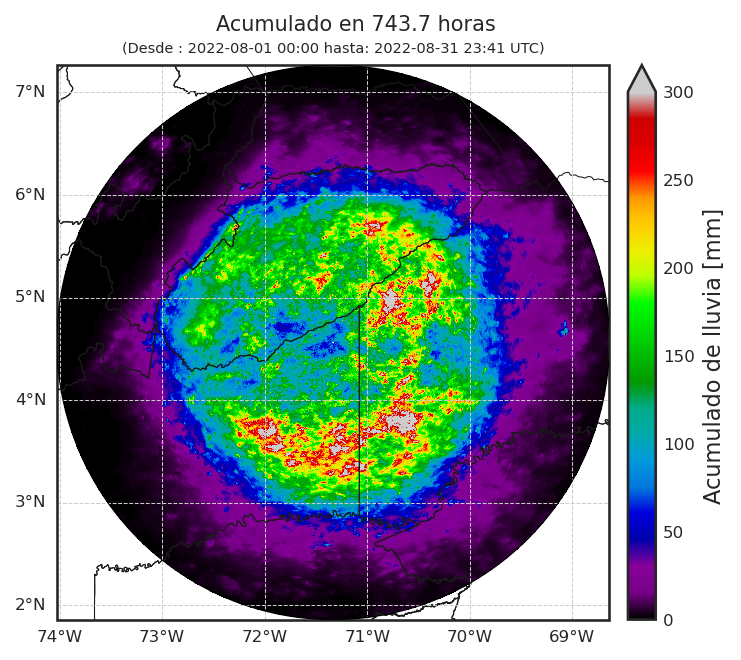

In [11]:
%%time
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
rr_depth.plot(x='x', y='y', cmap='nipy_spectral',
              cbar_kwargs={'label': "Acumulado de lluvia [mm]", 
                           'pad':0.025, 
                           }, 
              ax=ax, 
              transform=data_crs, 
              # norm=norm,
              vmin=0, 
              vmax=300,
             )
ax.set_title('')
cbar = ax.figure.axes[1]
cbar.tick_params(labelsize=8, size=0)

shape_feature = ShapelyFeature(Reader("/media/alfonso/drive/Alfonso/gis/dptos/Departamentos.shp").geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='w')
ax.add_feature(shape_feature, edgecolor='k', lw=0.5)
gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5)
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
circle_points = geodesic.Geodesic().circle(lat=ds.latitude.values,
                                                   lon=ds.longitude.values,
                                                   radius=ds.range.values[-1],
                                                   n_samples=10000, endpoint=False)
geom = shapely.geometry.Polygon(circle_points)
ax.add_geometries(geom, crs=ccrs.PlateCarree(), facecolor='none',
                               edgecolor='black', linewidth=0.5,  zorder=3)
gl.top_labels = False
gl.right_labels = False
diff = (test.vcp_time.isel(vcp_time=-1)- test.vcp_time.isel(vcp_time=0)).dt.days * 24  + (test.vcp_time.isel(vcp_time=-1)- test.vcp_time.isel(vcp_time=0)).dt.seconds / 3600
diff = np.round(diff.values, 1)
start = pd.to_datetime(test.vcp_time.values[0])
end =pd.to_datetime(test.vcp_time.values[-1])
ax.set_title(f'(Desde : {start:%Y-%m-%d %H:%M} hasta: {end:%Y-%m-%d %H:%M} UTC)', size=7)
fig.suptitle(f'Acumulado en {diff} horas', fontsize=10, y=0.95);

In [12]:
# start, end = dia_met(year=2022, month=8, day=9, num_days=3)
# start, end

In [13]:
# ds.sel(vcp_time=slice(f'{start:%Y%m%d %H%M}', f'{end:%Y%m%d %H%M}')).vcp_time

In [14]:
def plot_Rad_Est(rr, df, name="Carimagua"):
    ref = rr.hvplot.quadmesh(x='x',
                                 y='y',
                                 cmap='ChaseSpectral',
                                 clabel='Lluvia acumulada [mm]',
                                 title=f'{name} Radar',
                                 clim=(-0, 300),
                                 height=500,
                                 rasterize=True,
                                width=600)

    st = df.hvplot.scatter(x='longitud', y='latitud')

    return ref * st

In [15]:
path_df = '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua'
df = pd.read_csv(f"{path_df}/Estaciones_CARIMAGUA.csv", sep=";")

In [16]:
rr_depth.attrs['sweep_mode'] = 'azimuth_surveillance'
rr_mem = rr_depth.copy().pipe(georeference, crs=proj).load()
plot_Rad_Est(rr=rr_mem.compute(), df=df)

:DynamicMap   []
   :Overlay
      .Image.I   :Image   [x,y]   (DBZH)
      .Scatter.I :Scatter   [longitud]   (latitud)

In [17]:
class Sta_args:
    def __init__(self, cod, lat, lon):
        self.cod = cod
        self.lat = lat
        self.lon = lon


# def get_data()

In [18]:
args = [Sta_args(cod=row['CODIGO'], lat=row['latitud'], lon=row['longitud']) for _, row in df.iterrows()]

In [19]:
est = []
rad = []
cods = []
for _, row in df.iterrows():
    try:
        cod = row["CODIGO"]
        
        df_st = pd.read_csv(f'{path_df}/estaciones/{cod}-1.csv', index_col=0, parse_dates=True, 
                            on_bad_lines='skip', sep=';', decimal=',')
        df_st = df_st[df_st['raw_data']< 100]
        acc_st = df_st.loc['2022-08']['raw_data'].sum()
        acc_rad = get_lon_lat(rr=rr_depth, lat=row['latitud'], lon=row['longitud'], data_crs=data_crs)
        est.append(acc_st)
        rad.append(acc_rad)
        cods.append(cod)
    except (FileNotFoundError, KeyError) as e:
        print(e)
        continue
    

[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/35027002-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/2403700148-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/3502700146-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/3502700147-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/24035440-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/24035380-1.csv'
[Errno 2] No such file or directory: '/media/alfonso/drive/Alfonso/python/radar_data/data/Carimagua/estaciones/35097080-1.csv'
'2022-08'


In [20]:
df['CODIGO'] = df['CODIGO'].astype(str)

In [21]:
df_res = pd.DataFrame(data=np.array([est, rad, cods]).T, columns=['est', 'rad', 'CODIGO'])
df_res['CODIGO'] = df_res['CODIGO'].astype(int).astype(str)

In [22]:
df_res = df_res.merge(df[['CODIGO','Carimagua']], on='CODIGO')

In [23]:
df_res

,est,rad,CODIGO,Carimagua
0,156.2,127.911819,35225030,39.917241
1,98.6,0.122274,21206980,282.461133
2,89.8,16.545898,35085070,215.507033
3,175.7,0.172621,35025080,276.819936
4,0.0,164.475128,35237030,101.125033
...,...,...,...,...
116,0.0,2.218958,37045010,270.504986
117,0.0,0.213607,35035130,274.431716
118,0.0,1.254383,24027070,289.959857
119,0.0,0.632667,35027190,283.300683


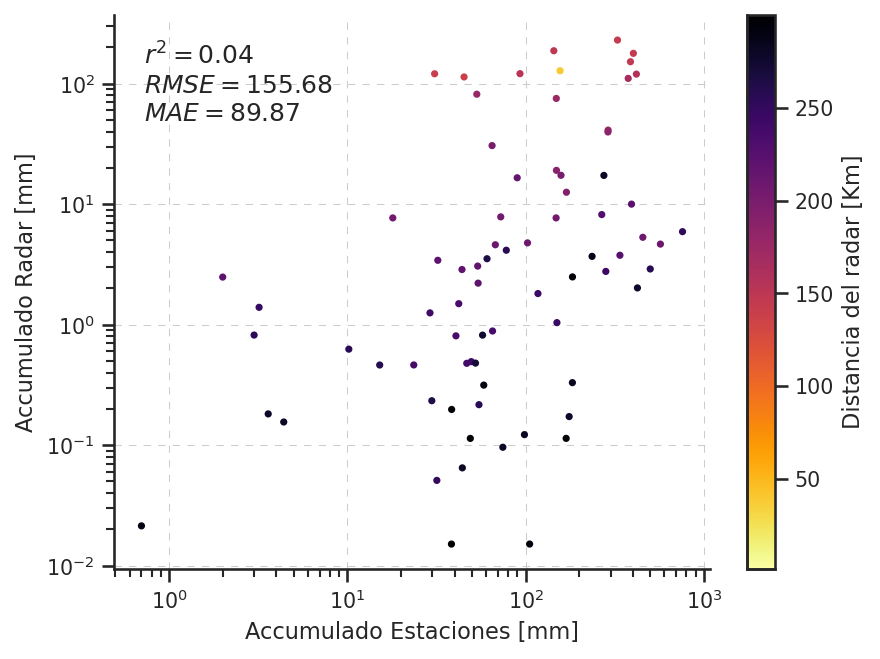

In [24]:
fig, ax = plt.subplots(dpi=150)
rmse, mae, corr1 = metrics_pd(df_res['est'], df_res['rad'])
sc = ax.scatter(df_res['est'], df_res['rad'], s=6, c=df_res['Carimagua'], cmap='inferno_r')
ax.set_xlabel("Accumulado Estaciones [mm]")
ax.set_ylabel("Accumulado Radar [mm]")
fig.colorbar(sc, ax=ax, label='Distancia del radar [Km]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')
sns.despine()